# Create surface mesh

Now that we have taken our `vtk` formatted mesh and have converted it to `stl` format, we can reconstruct a parametric surface using `gmsh`. This process is iterative, as there are processes in `gmsh` that do not always work.

## Testing `gmsh` package

We begin by making sure that we can use and create a mesh using `gmsh` from their standard examples and data. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
# Define filenames for capturing standard output and error
outfile = "out.txt"
errfile = "err.txt"

cwd = os.getcwd()
os.chdir('./data/gmsh_testcase')
# Open the output and error files in write mode
with open(outfile, 'w+') as fout:
    with open(errfile, 'w+') as ferr:
        # Start the Paraview script as a subprocess
        proc = subprocess.Popen(['gmsh', 'aneurysm.py'], # TODO: -nopopup option not being passed correctly 
                                stdout=fout, stderr=ferr)

# notice you must close out all windows created by gmsh to continue
proc.wait()

os.chdir(cwd)

## Initial surface mesh creation

Much of the mesh generation is based off of a working surface mesh that we have extracted from 3D slicer, or some other segmentation software. This requires an adequate surface mesh, which only sometimes has a decent surface, even after smoothing. In 3D slicer, this can be accomplished with some of the surface curation toolkit options. Those are out of the scope of this tutorial. 

Our process to generate a surface mesh is as follows:

- Check to see that the `gmsh` algorithm can recreate the surface (see the example script provided by `gmsh` named: `aneurysm.py`
- If it is successful, we can move on to create outlets
- If it is not successful, we need to curate the mesh

### 3D slicer mesh

The mesh we will first work on, is the STL conversion we imported from 3D-Slicer in the previous step. This mesh has not been curated at all, but has had some smoothing applied from before.

The mesh resides in `./data/testcase_output/convert_to_stl.stl` lets call the `recreate_mesh` function from the mesh processing module: `mesh.py`

In [3]:
from app.mesh import recreate_mesh

mesh_path = './data/step_01_output/convert_to_stl.stl'
recreate_mesh(mesh_path)



!!----------  Number of boundary entities: 0  ----------!!



This particular mesh file has been already cleaned in 3D-slicer, so it will generate without errors. However, we have also built in a check to see if the mesh we have has empty triangles from incomplete boundaries. 

### Paraview processing

In some cases, the surface extracted from 3D-slicer will have segmentation errors (leading to empty holes in the surface which `gmsh` flags are boundary entities). Other times, errors are due to non-uniform smoothing that leads `gmsh` to create some mesh locations that have extremely high curvature. Here we will process this mesh, and catch it with ParaView.

In [9]:
import os
from app.paraview_driver import run_script
from app.io import make_save_directory

desired_output_path = './data/step_02_output'
make_save_directory(desired_output_path)

paraview_pvbatch = '/home/carlosar/sfw/ParaView-5.11.2-MPI-Linux-Python3.9-x86_64/bin/pvbatch'
script_name = 'generate_curvature.py'
data_path = './data/step_01_output'
files = ['convert_to_stl.stl'] 
run_script(paraview_pvbatch, 
           script_name, 
           data_path,
           files,
           desired_output_path)


--------------------------------------------------------------------------------
running paraview script: generate_curvature.py
--------------------------------------------------------------------------------



<Popen: returncode: 0 args: ['/home/carlosar/sfw/ParaView-5.11.2-MPI-Linux-P...>

Here we plot the `Gauss Curvature` filter on the surface data, the square points are selected areas that have extremely high and low curvature. Some areas are locations where the surface mesh needs to be smoothed out, and other areas the surface mesh has artifacts from the segmentation. Once inspected, and curated, we can continue to the next step.

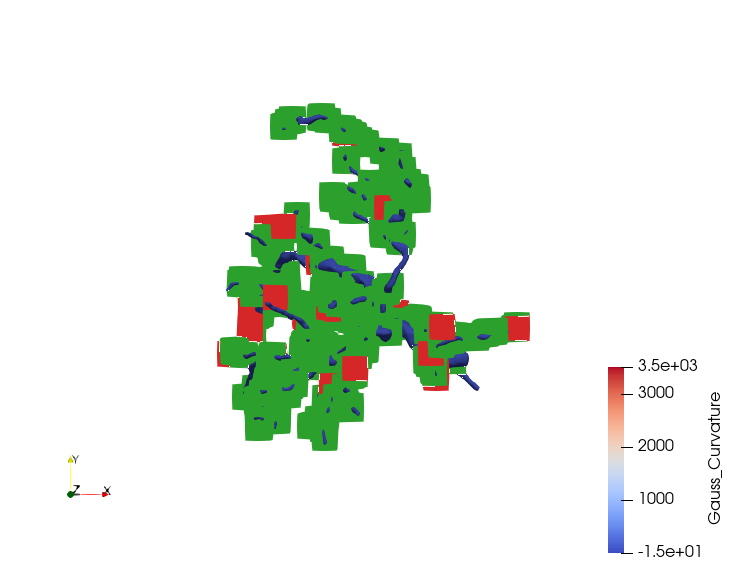

In [5]:
from IPython.display import Image

# Display the image
file_path = os.path.join(desired_output_path, 'generate_curvature.png')
Image(filename=file_path)